In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizerFast, BertModel, TFBertModel, AlbertModel, TFAlbertModel

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
strategy = tf.distribute.get_strategy()

In [3]:
# tokenizer_bert = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
# model_bert = BertModel.from_pretrained("kykim/bert-kor-base")

In [4]:
train = pd.read_csv("../dataset/train.csv", encoding='CP949')
test = pd.read_csv("../dataset/test.csv", encoding='CP949')

In [5]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,entailment


In [6]:
test.head()

,index,premise,hypothesis
0,1,진짜 사람하나 캐리어하나만 들어갈수있어요,캐리어는 들어갈 수 없어요.
1,2,그린 아메리카는 우선 대형 초콜릿 제조업체들을 대상으로 설득작업을 벌이고 있습니다.,초콜릿을 만드는 대형 제조업체가 존재한다.
2,3,또한 강연이 끝난 후 각 국의 업무 담당자들로부터 사전 접수한 질문과 함께 현장에서...,질의응답에 사전 접수된 질문은 답변이 제한된다.
3,4,수험생들은 각 상담부스에서 입시전문가나 입학사정관과 상담함으로써 수시모집 지원전략을...,수험생들은 입시전문가와 입학사정관에게 수시모집 지원전략에 대한 도움을 받을 수 있다.
4,5,콜린은 매우 친절하고 응답이 빠릅니다.,콜린이 숙소의 호스트입니다.


In [7]:
categorical_cols = ['label']
for e in categorical_cols:
    le = LabelEncoder()
    train[e] = le.fit_transform(train[e])

In [8]:
train.head()

,index,premise,hypothesis,label
0,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,0
1,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,1
2,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,2
3,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,2
4,5,이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...,코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.,1


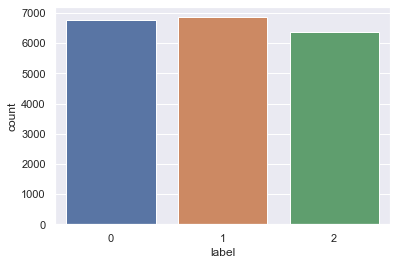

In [9]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

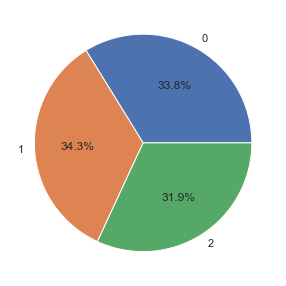

In [10]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

In [11]:
def model_BERT():
    with strategy.scope():
        encoder = TFBertModel.from_pretrained("kykim/bert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
model_bert = model_BERT()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")

In [14]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

In [15]:
train_encoded = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded['input_ids'], train.label.values, test_size=0.2)
x_test = test_encoded['input_ids']

In [17]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [18]:
model_bert.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 118297344 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 118,299,651
Trainable params: 118,299,651
Non-trainable params: 0
_________________________________________________________________


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model_bert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,validation_data=valid_dataset,epochs= 5)

Epoch 1/5
999/999 [==============================] - 220s 212ms/step - loss: 0.6706 - accuracy: 0.7160 - val_loss: 0.4590 - val_accuracy: 0.8320
Epoch 2/5
999/999 [==============================] - 210s 211ms/step - loss: 0.3704 - accuracy: 0.8568 - val_loss: 0.4908 - val_accuracy: 0.8400
Epoch 3/5
999/999 [==============================] - 208s 208ms/step - loss: 0.2199 - accuracy: 0.9173 - val_loss: 0.5942 - val_accuracy: 0.8370
Epoch 4/5
999/999 [==============================] - 209s 210ms/step - loss: 0.1259 - accuracy: 0.9541 - val_loss: 0.6669 - val_accuracy: 0.8472
Epoch 5/5
999/999 [==============================] - 208s 209ms/step - loss: 0.0748 - accuracy: 0.9732 - val_loss: 0.8414 - val_accuracy: 0.8432


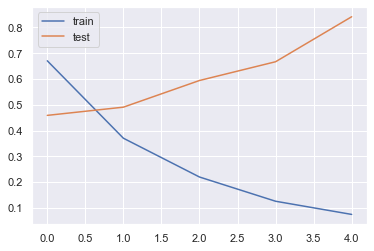

In [20]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
def model_ALBERT():
    with strategy.scope():
        encoder = TFAlbertModel.from_pretrained("kykim/albert-kor-base")

        input_layer = Input(shape=(100,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [25]:
model_albert = model_ALBERT()

Downloading:   0%|          | 0.00/52.8M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFAlbertModel.

All the layers of TFAlbertModel were initialized from the model checkpoint at kykim/albert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [26]:
tokenizer_albert = BertTokenizerFast.from_pretrained("kykim/albert-kor-base")

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

In [27]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

In [29]:
train_encoded = tokenizer_albert.batch_encode_plus(train_data, padding='max_length', max_length=100)
test_encoded = tokenizer_albert.batch_encode_plus(test_data, padding='max_length', max_length=100)

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded['input_ids'], train.label.values, test_size=0.2, random_state=42)
x_test = test_encoded['input_ids']

In [31]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [32]:
model_albert.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
tf_albert_model (TFAlbertMod TFBaseModelOutputWithPool 13186816  
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 2307      
Total params: 13,189,123
Trainable params: 13,189,123
Non-trainable params: 0
_________________________________________________________________


In [33]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

history = model_bert.fit(train_dataset,steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,validation_data=valid_dataset,epochs= 5)

Epoch 1/5
 45/999 [>.............................] - ETA: 5:34 - loss: 0.2179 - accuracy: 0.9444

KeyboardInterrupt: 